# EdNet-KT1 Data Analysis

## Columns Description

|  Field   | Annotation  |
|  ----  | ----  |
| user_id  | student's id |
| timestamp  |  the moment the question was given, represented as Unix timestamp in milliseconds |
| solving_id  | represents each learning session of students corresponds to each bunle. It is a form of single integer, starting from 1 |
| question_id  | the ID of the question that given to student, which is a form of q{integer} |
| user_answer  | the answer that the student submitted, recorded as a character between a and d inclusively |
| elapsed_time  | the time that the students spends on each question in milliseconds |

## Statement for Our Data Set

There are 784309 tables in our data set. Each table describes a student's question-solving log. There is no difference in the information dimension between the tables. Each table contains the `timestamp`,`solving_id`,`question_id`,`user_answer` and `elapsed_time` as described in the above `Columns Description` section.

In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

## Record Example
We randomly selected 5000 tables from all the students for analysis,which accounted for about 0.64% of the total data set, and added a column named `user_id` to the original table

In [2]:
import os
path=r'D:\EdNet-KT1\KT1'
d=[]
table_list=[]
s=pd.Series(os.listdir(path))
file_selected=s.sample(5000).to_numpy()
for file_name in file_selected:
    data_raw=pd.read_csv(path+'\\'+file_name,encoding = "ISO-8859-15")
    data_raw['user_id']=pd.Series([file_name[:-4]]*len(data_raw))
    d.append([file_name[:-4],len(data_raw)])
    data=pd.DataFrame(data_raw,columns=['user_id']+data_raw.columns.to_list()[:-1])
    table_list.append(data)
df=pd.concat(table_list)
pd.set_option('display.max_rows',10)
df=df.reset_index(drop=True)
df

user_id      timestamp  solving_id question_id user_answer  \
0       u717875  1565332027449           1       q4862           d   
1       u717875  1565332057492           2       q6747           d   
2       u717875  1565332085743           3        q326           c   
3       u717875  1565332116475           4       q6168           a   
4       u717875  1565332137148           5        q847           a   
...         ...            ...         ...         ...         ...   
574251  u177603  1530371808931          15       q6984           b   
574252  u177603  1530372197614          16       q7335           c   
574253  u177603  1530372198181          16       q7336           a   
574254  u177603  1530372198879          16       q7337           c   
574255  u177603  1530372199425          16       q7338           b   

        elapsed_time  
0              45000  
1              24000  
2              25000  
3              27000  
4              17000  
...              ...  
574251         44250  
574252         95750  
574253         95750  
574254         95750  
574255         95750  

[574256 rows x 6 columns]

## General Feature

In [3]:
df.describe()

timestamp     solving_id  elapsed_time
count  5.742560e+05  574256.000000  5.742560e+05
mean   1.546425e+12     875.902859  2.599017e+04
std    2.019656e+10    1941.978009  3.376126e+04
min    1.494451e+12       1.000000  0.000000e+00
25%    1.531720e+12      77.000000  1.600000e+04
50%    1.548410e+12     311.000000  2.100000e+04
75%    1.564817e+12     900.000000  3.000000e+04
max    1.575306e+12   18039.000000  7.650000e+06

In [4]:
len(df.question_id.unique())

11838

This shows there are totally 11838 questions.

## Missing Value

In [5]:
print('Part of missing values for every column')
print(df.isnull().sum() / len(df))

Part of missing values for every column
user_id         0.000000
timestamp       0.000000
solving_id      0.000000
question_id     0.000000
user_answer     0.000556
elapsed_time    0.000000
dtype: float64


This indicates that there are no missing values in all columns except `user_answer`. A missing value in `user_answer` indicates that some students did not choose an option.

In [6]:
df.fillna('not choose',inplace=True)

Fill in `not choose` in the position of the missing value

## Sort user_id

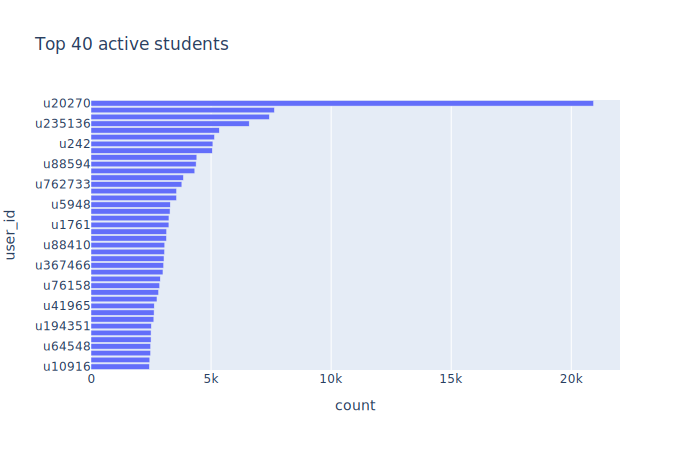

In [7]:
user_count_table=pd.DataFrame(d,columns=['user_id','count'])
ds=user_count_table.sort_values(by=['count'],axis=0).tail(40)
fig = px.bar(
    ds,
    x = 'count',
    y = 'user_id',
    orientation='h',
    title='Top 40 active students'
)

fig.show("svg")

We use the number of questions that students have done as an indicator of whether a student is active. This figure shows the 40 most active students.

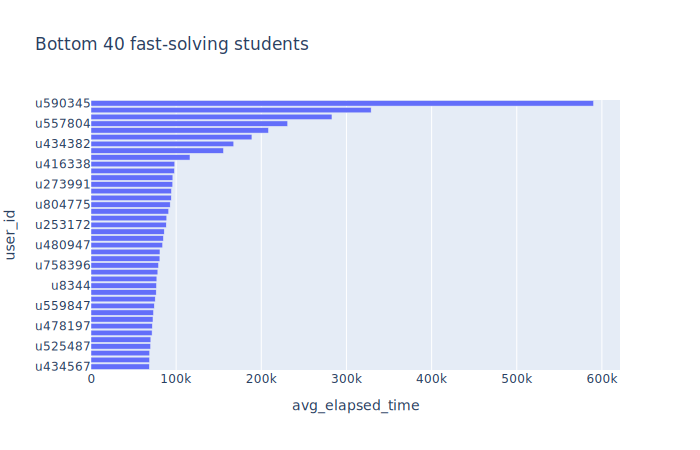

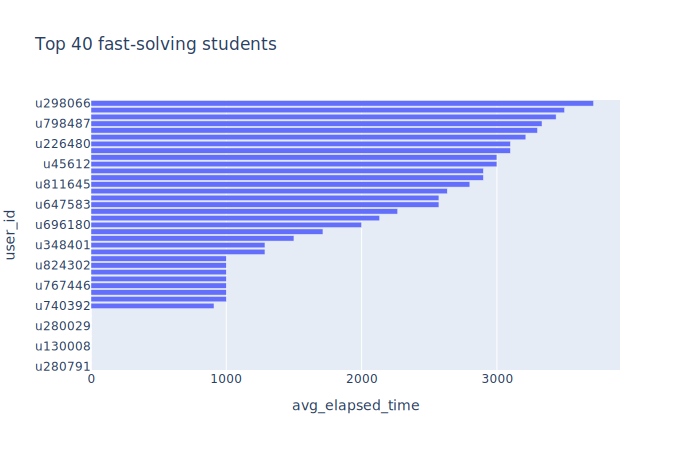

In [8]:
ds=df.loc[:,['user_id','elapsed_time']].groupby('user_id').mean()
ds=ds.reset_index(drop=False)
ds.columns=['user_id','avg_elapsed_time']
ds_tail=ds.sort_values(by=['avg_elapsed_time'],axis=0).tail(40)

fig_tail = px.bar(
    ds_tail,
    x = 'avg_elapsed_time',
    y = 'user_id',
    orientation='h',
    title='Bottom 40 fast-solving students '
)
fig_tail.show("svg")
ds_head=ds.sort_values(by=['avg_elapsed_time'],axis=0).head(40)
fig_head = px.bar(
    ds_head,
    x = 'avg_elapsed_time',
    y = 'user_id',
    orientation='h',
    title='Top 40 fast-solving students'
)
fig_head.show("svg")

We take the average time it takes students to do a question as an indicator of how fast students do it. These two figures respectively show the fastest and slowest students among the 5000 students, and the average time they spent doing the problems.

Note that some students spend very little time doing the questions, and the time is almost zero. We can almost judge that these students did not do the questions at all, and they chose blindly. We remove these students and rearrange them

In [9]:
bound=5000 # If the average time of doing the topic is less than 5000, it means that the student is most likely to be bad
ds=df.loc[:,['user_id','elapsed_time']].groupby('user_id').mean()
ds=ds.reset_index(drop=False)
ds.columns=['user_id','avg_elapsed_time']
bad_user_ids=ds[ds['avg_elapsed_time']<bound]['user_id'].to_list()
df_drop=df.drop(df[df['user_id'].isin(bad_user_ids)].index)
print('bad students number is ',len(bad_user_ids))
print('length of table after dropping is ',len(df_drop))

bad students number is  61
length of table after dropping is  567778


### After dropping

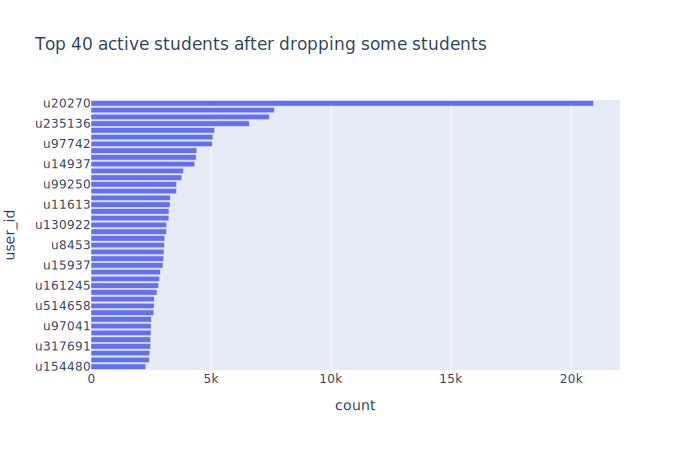

In [10]:
ds=df_drop['user_id'].value_counts().reset_index(drop=False)
ds.columns=['user_id','count']
ds_tail=ds.sort_values(by=['count'],axis=0).tail(40)
fig_tail = px.bar(
    ds_tail,
    x = 'count',
    y = 'user_id',
    orientation='h',
    title='Top 40 active students after dropping some students'
)
fig_tail.show("svg")

This figure shows the 40 most active students after dropping some bad students.

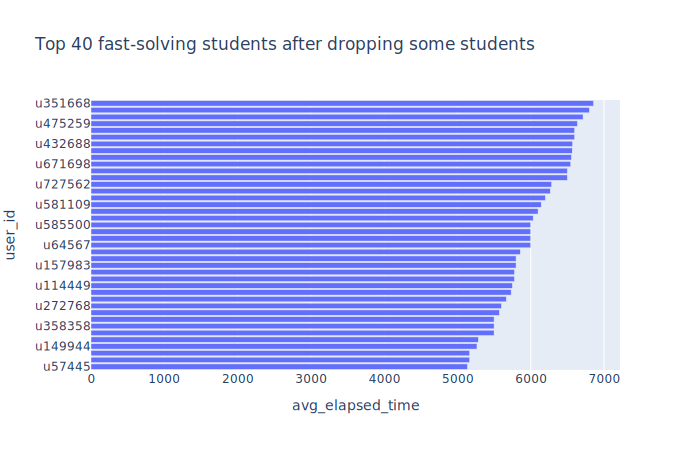

In [11]:
ds=df_drop.loc[:,['user_id','elapsed_time']].groupby('user_id').mean()
ds=ds.reset_index(drop=False)
ds.columns=['user_id','avg_elapsed_time']

ds_head=ds.sort_values(by=['avg_elapsed_time'],axis=0).head(40)
fig_head = px.bar(
    ds_head,
    x = 'avg_elapsed_time',
    y = 'user_id',
    orientation='h',
    title='Top 40 fast-solving students after dropping some students'
)
fig_head.show("svg")

This figure respectively show the more reasonable fastest students among the 5000 students than before, and the average time they spent doing the problems.

## Sort question_id

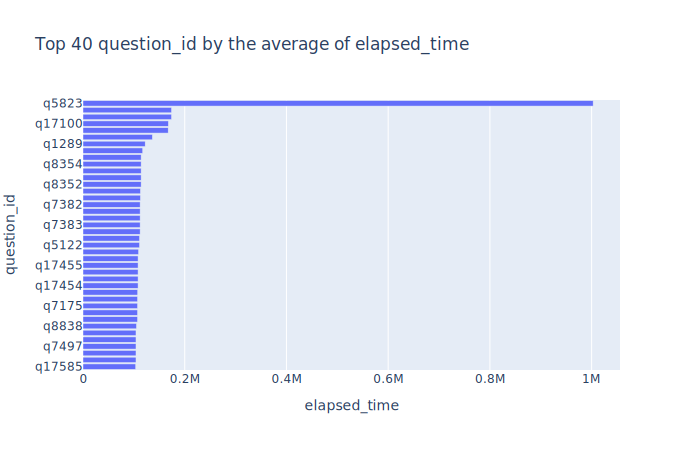

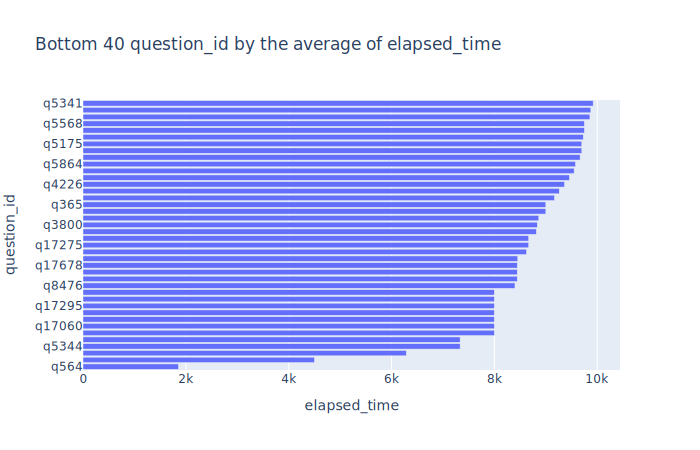

In [12]:
ds=df.loc[:,['question_id','elapsed_time']].groupby('question_id').mean()
ds=ds.reset_index(drop=False)
ds_tail=ds.sort_values(by=['elapsed_time'],axis=0).tail(40)
fig_tail = px.bar(
    ds_tail,
    x = 'elapsed_time',
    y = 'question_id',
    orientation='h',
    title='Top 40 question_id by the average of elapsed_time'
)
fig_tail.show("svg")
ds_head=ds.sort_values(by=['elapsed_time'],axis=0).head(40)
fig_head = px.bar(
    ds_head,
    x = 'elapsed_time',
    y = 'question_id',
    orientation='h',
    title='Bottom 40 question_id by the average of elapsed_time'
)
fig_head.show("svg")

We can judge the difficulty of this question from the average time spent on a question.  
These two figures reflect the difficulty of the questions and shows the ids of the 40 most difficult and 40 easiest questions.s

## Appearence of Questions

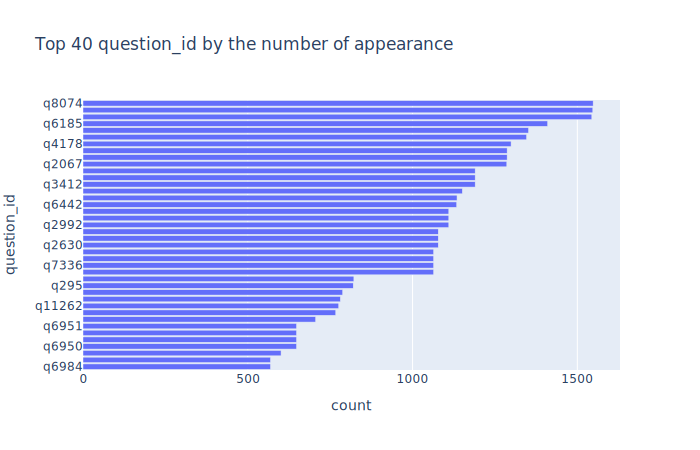

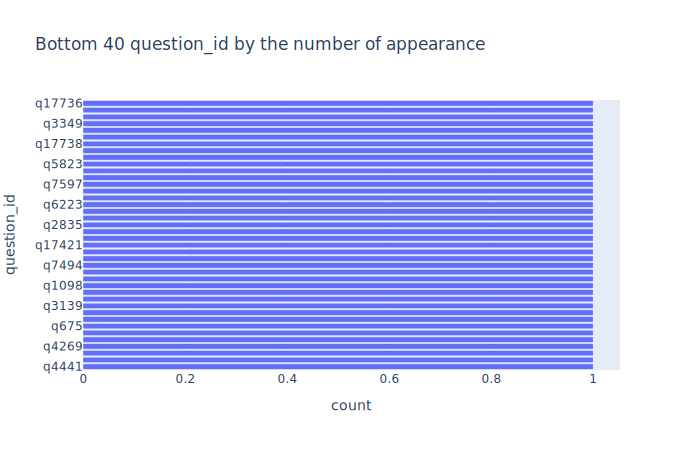

In [13]:
ds=df['question_id'].value_counts().reset_index(drop=False)
ds.columns=['question_id','count']
ds_tail=ds.sort_values(by=['count'],axis=0).tail(40)
fig_tail = px.bar(
    ds_tail,
    x = 'count',
    y = 'question_id',
    orientation='h',
    title='Top 40 question_id by the number of appearance'
)
fig_tail.show("svg")
ds_head=ds.sort_values(by=['count'],axis=0).head(40)
fig_head = px.bar(
    ds_head,
    x = 'count',
    y = 'question_id',
    orientation='h',
    title='Bottom 40 question_id by the number of appearance'
)
fig_head.show("svg")

These two images reflect the 40 questions that were drawn the most frequently and the 40 questions that were drawn the least frequently

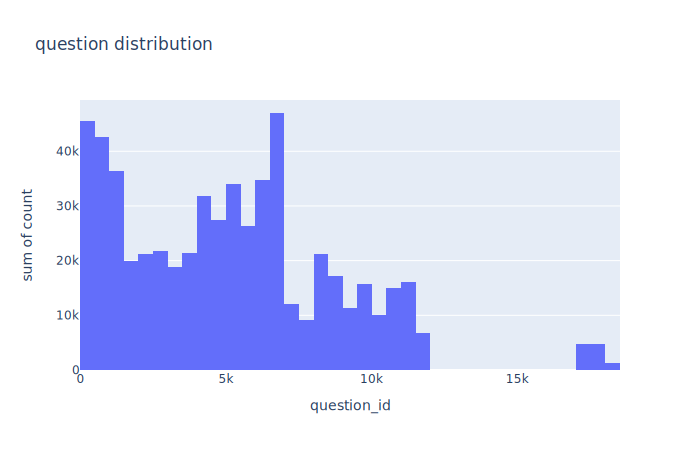

In [14]:
ds2=df['question_id'].value_counts().reset_index(drop=False)
ds2.columns=['question_id','count']
def convert_id2int(x):
    return pd.Series(map(lambda t:int(t[1:]),x))  
ds2['question_id']=convert_id2int(ds2['question_id'])
ds2.sort_values(by=['question_id'])
fig = px.histogram(
    ds2,
    x = 'question_id',
    y = 'count',
    title='question distribution'
)
fig.show("svg")

##  Question's Option Selected Most Frequently

In [15]:
ds=df.loc[:,['question_id','user_answer','user_id']].groupby(['question_id','user_answer']).count()

most_count_dict={}
for id in df.question_id.unique():
    most_count=ds.loc[id].apply(lambda x:x.max())[0]
    most_count_dict[id]=most_count
ds2=ds.apply(lambda x:x-most_count_dict[x.name[0]],axis=1)
ds2=ds2[ds2.user_id==0]
ds2=ds2.reset_index(drop=False).loc[:,['question_id','user_answer']]
ds2.columns=['question_id','most_answer']
ds2.index=ds2['question_id']
ds2['most_answer']

question_id
q1        b
q10       d
q100      c
q1000     c
q10000    b
         ..
q9995     d
q9996     a
q9997     d
q9998     a
q9999     b
Name: most_answer, Length: 12215, dtype: object

This shows the most selected options (including `not choose`) for each question.   
Note that if there are multiple options for a question to be selected most frequently, the table will also contain them.

## Choices Distribution

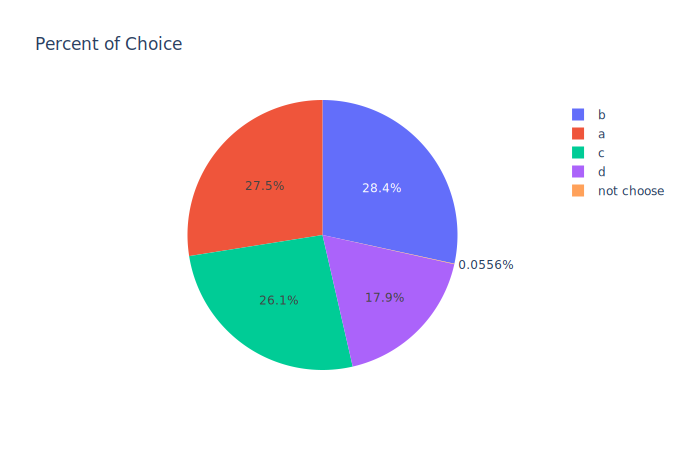

In [16]:
ds = df['user_answer'].value_counts().reset_index(drop=False)
ds.columns = ['user_answer', 'percent']

ds['percent']=ds['percent']/len(df)
ds = ds.sort_values(by=['percent'])

fig = px.pie(
    ds,
    names = ds['user_answer'],
    values = 'percent',
    title = 'Percent of Choice'    
)

fig.show("svg")

We use a pie chart to show the distribution of the proportions of `a`, `b`, `c`, `d` and `not choose` among the options selected by the 5000 students.

## Sort By Time Stamp

In [17]:
import time
import datetime

In [18]:
df_time=df.copy()
columns=df.columns.to_list()
columns[1]='time'
df_time.columns=columns
df_time['time'] /= 1000
df_time['time']=pd.Series(map(datetime.datetime.fromtimestamp,df_time['time']))
df_time

user_id                    time  solving_id question_id user_answer  \
0       u717875 2019-08-09 14:27:07.449           1       q4862           d   
1       u717875 2019-08-09 14:27:37.492           2       q6747           d   
2       u717875 2019-08-09 14:28:05.743           3        q326           c   
3       u717875 2019-08-09 14:28:36.475           4       q6168           a   
4       u717875 2019-08-09 14:28:57.148           5        q847           a   
...         ...                     ...         ...         ...         ...   
574251  u177603 2018-06-30 23:16:48.931          15       q6984           b   
574252  u177603 2018-06-30 23:23:17.614          16       q7335           c   
574253  u177603 2018-06-30 23:23:18.181          16       q7336           a   
574254  u177603 2018-06-30 23:23:18.879          16       q7337           c   
574255  u177603 2018-06-30 23:23:19.425          16       q7338           b   

        elapsed_time  
0              45000  
1              24000  
2              25000  
3              27000  
4              17000  
...              ...  
574251         44250  
574252         95750  
574253         95750  
574254         95750  
574255         95750  

[574256 rows x 6 columns]

This table shows the result of converting unix timestamp to datetime format

### question distribution by time

In [19]:
ds_time_question=df_time.loc[:,['time','question_id']]
ds_time_question=ds_time_question.sort_values(by=['time'])
ds_time_question

time question_id
503014 2017-05-11 05:17:10.922        q129
503015 2017-05-11 05:17:34.561       q8058
503016 2017-05-11 05:17:56.806       q8120
503017 2017-05-11 05:18:22.591        q157
503018 2017-05-11 05:18:43.085         q52
...                        ...         ...
108215 2019-12-03 00:48:27.437        q776
108216 2019-12-03 00:59:38.437      q10847
108217 2019-12-03 00:59:38.437      q10844
108218 2019-12-03 00:59:38.437      q10845
108219 2019-12-03 00:59:38.437      q10846

[574256 rows x 2 columns]

This table shows the given questions in chronological order.And we can see that the earliest question q127 is on May 11, 2017, and the latest question q10846 is on December 3, 2019.

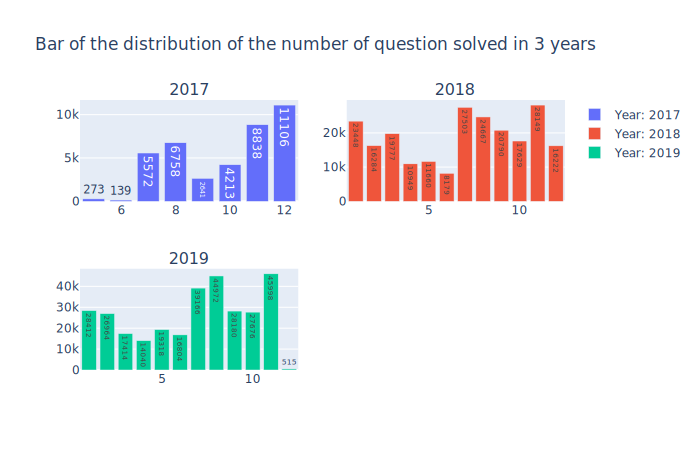

In [20]:
ds_time_question['year']=pd.Series(map(lambda x :x.year,ds_time_question['time']))
ds_time_question['month']=pd.Series(map(lambda x :x.month,ds_time_question['time']))
ds=ds_time_question.loc[:,['year','month']].value_counts()

years=ds_time_question['year'].unique()
years.sort()
fig=make_subplots(
    rows=2,
    cols=2,
    start_cell='top-left',
    subplot_titles=tuple(map(str,years))
)
traces=[
    go.Bar(
        x=ds[year].reset_index().sort_values(by=['month'],axis=0)['month'].to_list(),
        y=ds[year].reset_index().sort_values(by=['month'],axis=0)[0].to_list(),
        name='Year: '+str(year),
        text=[ds[year][month] for month in ds[year].reset_index().sort_values(by=['month'],axis=0)['month'].to_list()],
        textposition='auto'
    ) for year in years
]
for i in range(len(traces)):
    fig.append_trace(traces[i],(i//2)+1,(i%2)+1)

fig.update_layout(title_text='Bar of the distribution of the number of question solved in {} years'.format(len(traces)))
fig.show('svg')

1. These three figures show the distribution of the number of problems solved in each month of 2017, 2018, and 2019.  
2. And the number of questions solved is gradually increasing.  
3. And the number of questions solved in March, 4, May, and June is generally small.

### user distribution by time

In [21]:
ds_time_user=df_time.loc[:,['user_id','time']]
ds_time_user=ds_time_user.sort_values(by=['time'])
ds_time_user

user_id                    time
503014  u21056 2017-05-11 05:17:10.922
503015  u21056 2017-05-11 05:17:34.561
503016  u21056 2017-05-11 05:17:56.806
503017  u21056 2017-05-11 05:18:22.591
503018  u21056 2017-05-11 05:18:43.085
...        ...                     ...
108215   u9476 2019-12-03 00:48:27.437
108216   u9476 2019-12-03 00:59:38.437
108217   u9476 2019-12-03 00:59:38.437
108218   u9476 2019-12-03 00:59:38.437
108219   u9476 2019-12-03 00:59:38.437

[574256 rows x 2 columns]

This table shows the students who did the questions in order of time.And we can see that the first student who does the problem is u21056, and the last student who does the problem is u9476.

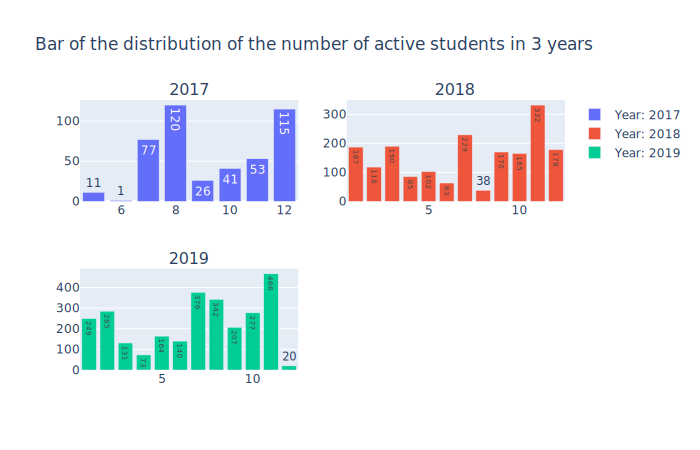

In [22]:
ds_time_user=df_time.loc[:,['user_id','time']]
ds_time_user=ds_time_user.sort_values(by=['time'])
ds_time_user['year']=pd.Series(map(lambda x :x.year,ds_time_user['time']))
ds_time_user['month']=pd.Series(map(lambda x :x.month,ds_time_user['time']))
ds_time_user.drop(['time'],axis=1,inplace=True)
ds=ds_time_user.groupby(['year','month']).nunique()

years=ds_time_user['year'].unique()
years.sort()
fig=make_subplots(
    rows=2,
    cols=2,
    start_cell='top-left',
    subplot_titles=tuple(map(str,years))
)
traces=[
    go.Bar(
        x=ds.loc[year].reset_index()['month'].to_list(),
        y=ds.loc[year].reset_index()['user_id'].to_list(),
        name='Year: '+str(year),
        text=[ds.loc[year].loc[month,'user_id'] for month in ds.loc[year].reset_index()['month'].to_list()],
        textposition='auto'
    ) for year in years
]
for i in range(len(traces)):
    fig.append_trace(traces[i],(i//2)+1,(i%2)+1)

fig.update_layout(title_text='Bar of the distribution of the number of active students in {} years'.format(len(traces)))
fig.show('svg')

1. These three graphs respectively show the number of students active on the system in each month of 2017, 2018, and 2019.  
2. And we can see that the number of active students in 2019 is generally more than that in 2018, and there are more in 2018 than in 2017, indicating that the number of users of the system is gradually increasing.  
3. Note that the number of students is not repeated here